In [2]:
%matplotlib widget
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import seaborn as sns
#import tensorflow as tf

from grabber import *
from binance.client import Client

mpl.rcParams['figure.figsize'] = (12, 14)
mpl.rcParams['axes.grid'] = False


Escolha do symbol, tamanho das candles, e período do mercado.

In [3]:

symbol="AVAXUSDT"
tframe = "5m"
startTime = "18 Nov, 2021"
endTime = None


Inicializar o cliente e pegar as candles.

In [4]:
client=Client()
grab = Grabber(client)
grab.get_historical_ohlcv(symbol=symbol, tframe=tframe, startTime=startTime)

c:\Users\Igor Strozzi\.cloned\turbo-dolloplow\grabber.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dohlcv[0] = pd.to_datetime(dohlcv[0], unit="ms")


In [5]:
#criando uma nova variável pros dados e checkando os mesmos
df = grab.ohlcvs[symbol]
df.tail(3)

,open,high,low,close,volume
date,,,,,
2021-11-22 17:05:00,141.16,141.64,140.25,141.22,18211.69
2021-11-22 17:10:00,141.20,141.80,141.07,141.15,8929.25
2021-11-22 17:15:00,141.12,141.20,139.58,140.31,33894.66


# 1 Determinação de janelas
$\mathrm{ma_{w_1}}$ é a moving average com janela $w_1$; $\mathrm{ema_{w_1}}$ é a exponential moving average com janela $w_1$. Em geral o desvio-padrão pra uma média de janela $w_1$ vai ser escrito como $\mathrm{std}_{w_1}$, contanto que não haja mais de uma média com essa janela; ou, então, será escrito como $\mathrm{std}(M_1)$, se dada alguma média $M_1$. A média aritmética simples de um conjunto, lista ou vetor será simplesmente $\mathrm{mean}$.
Serão necessárias pelo menos duas médias dos preços, ambas exponenciais, uma de cauda mais curta e outra de cauda mais longa. Seja $C$ o vetor de preços. 
A média de cauda mais curta, $M_1 = \mathrm{ema_{w_1}}(C)$, tem que satisfazer a propriedade:
$$\frac{\mathrm{mean}(\mathrm{std}(M_1))}{\mathrm{mean}(M_1)} > \mathrm{fee} + \varepsilon $$

sendo $\mathrm{fee}$ o custo percentual total das taxas de transação (0.08% na binance) e $\varepsilon$ um parâmetro do programa. A idéia é que o $\varepsilon$ determine uma "margem de segurança", enquanto o lado esquerdo da equação mede o quanto, percentualmente, o desvio-padrão médio corresponde ao preço médio. Ou seja, tendo uma janela $w_1$ seguramente (o que é determinado por $\varepsilon$) maior que o que se paga de taxa nas transações, temos uma primeira garantia, a de que, aproveitada suficientemente bem a volatilidade, ie, aberto um long suficientemente perto do "bottom" médio, a

In [6]:

fee = 0.08
e = 0.08
w1 = 3
w2 = 12

pmean1 = df.close.ewm(span=w1).mean()
pstd1 = df.close.ewm(span=w1).std()



pmean2 = df.close.ewm(span=w2).mean()
pstd2 = df.close.ewm(span=w2).std()


In [7]:


hmean1 = df.high
lmean1 = df.low

hmean2 = df.high.ewm(span=w1).mean()
lmean2 = df.low.ewm(span=w1).mean()

hmean3 = df.high.ewm(span=w2).mean()
lmean3 = df.low.ewm(span=w2).mean()

global_volatility = (((hmean1/lmean1).mean()-1)*100)
local_volatility1 = (hmean2.iloc[-1]/lmean2.iloc[-1] - 1)*100
local_volatility2 = (hmean3.iloc[-1]/lmean3.iloc[-1] - 1)*100


In [8]:
global_volatility, local_volatility1, local_volatility2 # %

(0.8564592582469777, 0.9458988796182677, 0.9714383563467655)

In [9]:
pstd1.mean(), pstd2.mean()

(0.6022564772976488, 1.1143802737561115)

In [10]:
local_volatility1 > fee + e

True

In [14]:
pmean1.iloc[-1]*(1+pstd2.iloc[-1]/100)

142.90884794959211

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
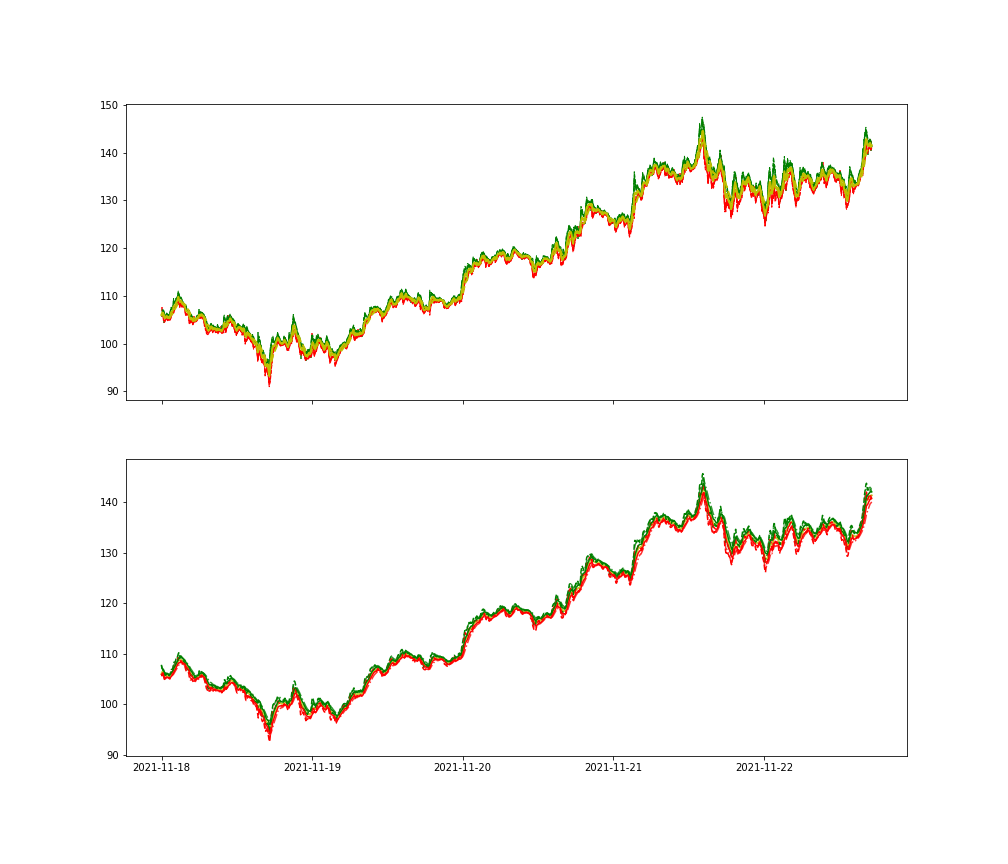

In [13]:


# pstd2 = df.close.ewm(span=w2).std()

# def showcurves(c1):

#   fig, ax = plt.subplots()
#   ax.set_title('click on points')

#   line, = ax.plot(np.random.rand(100), 'o',
#                   picker=True, pickradius=5)  # 5 points tolerance
#   plt.show()

#   return fig, ax, lineaa


fig, axs = plt.subplots(figsize=(14, 12), nrows=2, sharex="all", gridspec_kw={"height_ratios": [1, 1]})
# fig = plt.figure(figsize=(12, 12))
# ax = plt.axes()
ax1, ax2 = axs

ax1.plot(df.close, c="w", label=f"closes", linewidth=2)
ax1.plot(pmean1+1.1*pstd1, "g--", label=f"closes {w1} ema", linewidth=1.5)
ax1.plot(pmean1-1.1*pstd1, "r--", label=f"closes {w1} ema", linewidth=1.5)
ax1.plot(pmean1+1.25*pstd1, "g--", label=f"closes {w1} ema", linewidth=1.0)
ax1.plot(pmean1-1.25*pstd1, "r--", label=f"closes {w1} ema", linewidth=1.0)
ax1.plot(pmean1+1.5*pstd1, "g--", label=f"closes {w1} ema", linewidth=1.0)
ax1.plot(pmean1-1.5*pstd1, "r--", label=f"closes {w1} ema", linewidth=1.0)
ax1.plot(pmean1+1.75*pstd1, "g--", label=f"closes {w1} ema", linewidth=1.0)
ax1.plot(pmean1-1.75*pstd1, "r--", label=f"closes {w1} ema", linewidth=1.0)
ax1.plot(pmean1, "y-", linewidth=2, label=f"closes {w1} ema", alpha=1)
ax1.plot(pmean2, "y--", linewidth=2, label=f"closes {w2} ema", alpha=1)

ax2.plot(df.close, c="w", label=f"closes", linewidth=2)
# ax2.plot(pmean1+1.1*pstd1, "m--", label=f"closes {w1} ema", linewidth=1.5)
# ax2.plot(pmean1-1.1*pstd1, "m--", label=f"closes {w1} ema", linewidth=1.5)
# ax2.plot(pmean1, "b-", linewidth=2, label=f"closes {w1} ema", alpha=0.8)
ax2.plot(pmean2, "y-", linewidth=2, label=f"closes {w2} ema", alpha=0.8)
ax2.plot(pmean2+0.8*pstd2, "g-.", alpha=0.8)
ax2.plot(pmean2-0.8*pstd2, "r-.", alpha=0.8)
ax2.plot(hmean2, "g--", alpha=1)
ax2.plot(lmean2, "r--", alpha=1)
ax2.plot(hmean3, "g-", alpha=1)
ax2.plot(lmean3, "r-", alpha=1)
# including upper limits

yerrs = [df.high-df.close, df.low-df.close]

mom1 = df.close - df.close.shift(1)

colors = ["green" if c > 0 else "red" for c in mom1]
# reds = (mom1 <= 0).map(lambda _: "red" if True else "green")

ax1.vlines(df.index, ymin=df.close+yerrs[1], ymax=yerrs[0]+df.close, color=colors, alpha=1)
# ax.axhspan(yerrs[0], yerrs[1], facecolor='0.5')
# colors = (sums.loc[sums <= 0].index).map(lambda: "red" if True)
# if 
# ax.errorbar(df.index, df.close, yerr=yerrs,
#              linestyle="-", linewidth=1.5, ecolor="m")
# ax.errorbar(df.index, df.close, yerr=df.close-df.low,
#              linestyle="-", linewidth=2.0, color="red")
# ax.errorbar(df.index, pmean1,  uplims=df.high-df.close, lolims=df.close - df.low,
#              label='subsets of uplims and lolims')
# # including lower limits
# ax.errorbar(x, y + 1.0, xerr=xerr, yerr=yerr, lolims=lolims,
#             linestyle=ls);
# fig.show()


In [ ]:
"TODO: backtest; real-time paper trading (get websockets working, process their data, apply strategy, register results etc)"

In [12]:
longs = df.low <= (pmean1-1.1*pstd1)

In [13]:
shorts = df.high >= pmean1+1.1*pstd1

In [14]:
longs

date
2021-11-18 00:00:00    False
2021-11-18 00:01:00    False
2021-11-18 00:02:00    False
2021-11-18 00:03:00     True
2021-11-18 00:04:00     True
                       ...  
2021-11-21 00:57:00    False
2021-11-21 00:58:00     True
2021-11-21 00:59:00    False
2021-11-21 01:00:00     True
2021-11-21 01:01:00    False
Length: 4382, dtype: bool

In [ ]:

pmean1, pstd1, pmean2, pstd2

In [41]:

std_mean1 = pstd1/pmean1


In [42]:
std_mean1.mean()*100 # escolher w1 w2 de forma q isso seja maior que a fee de 0.08%

0.11339191790541209

In [ ]:
std_mean2 = pstd2/pmean2


In [ ]:
std_mean2.mean()*100


In [ ]:
df.close

In [ ]:

pdifhl = (df.high.shift(-w1) -df.low)/df.high.shift(-w1)*100


In [ ]:
pdif = (df.close.shift(-w1) - df.close)/df.close.shift(-w1)*100

In [ ]:
posdiffs = pdif >= 0
negdiffs = pdif < 0

In [ ]:
diffs = negdiffs*0 + posdiffs*1 #esse é o alvo: dizer se em w1 a diff é positiva ou negativa


In [ ]:
diffs.head(100).plot()



In [ ]:
#agora tenho que colocar as features mais adequadas pra esse alvo

In [ ]:

def feature_engineer(df, w: int, p: int):
  df.rolling.stdev(append=True)

In [ ]:
df.ta.cci(append=True)
df.ta.cg(append=True)
df.ta.roc(append=True)
df.ta.cci(append=True)
df.ta.pvo(append=True)
df.ta.stochrsi(append=True)

df.ta.entropy(append=True)
df.ta.kurtosis(append=True)
df.ta.median(append=True)
df.ta.skew(append=True)
df.ta.stdev(append=True)
df.ta.dpo(lookahead=False, append=True)
# kldf.ta.increasing(append=True)
# kldf.ta.decreasing(append=True)
df.ta.aberration(append=True)
df.ta.natr(append=True)
df.ta.massi(append=True)
df.ta.pdist(append=True)
df.ta.rvi(append=True)
df = df.dropna()
df.index
date_time = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')


# plot_cols = ["close", "PDIST"]
# plot_features = df[plot_cols]
# plot_features.index = date_time
# _ = plot_features.plot(subplots=True)

# plot_features = df[plot_cols][:480]
# plot_features.index = date_time[:480]
# _ = plot_features.plot(subplots=True)



In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]



In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


 Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)



In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


def plot(self, model=None, plot_col='close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot


def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


# The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example



In [ ]:

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

 Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

 The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['close'])



w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['close'])


single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['close'])
single_step_window





In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline(label_index=column_indices['close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)



In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['close'])

wide_window


print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


wide_window.plot(baseline)





In [ ]:
CONV_WIDTH = 6
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['close'])

conv_window


In [ ]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")




 Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match:

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['close'])

wide_conv_window


In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])



In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


In [ ]:
wide_window.plot(lstm_model)


In [ ]:
train_x

 ### Performance

 With this dataset typically each of the models does slightly better than the one before it.

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


 ### Multi-output models

 The models so far all predicted a single output feature, `T (degC)`, for a single time step.

 All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.


In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


 Note above that the `features` axis of the labels now has the same depth as the inputs, instead of 1.

 #### Baseline

 The same baseline model can be used here, but this time repeating all features instead of selecting a specific `label_index`.

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)


 #### Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])


In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


 #### RNN


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()
